In [1]:
import os
import re
import datetime as dt
import time

import scipy as sp
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
import suncalc

import rads_extraction
import datetime_tools as dt_extra
from directory_paths import project_dir as pj

date = '2024-01-22'

In [2]:
def init_earth(earth):
    earth.drawcoastlines(color='#555566', linewidth=0.5, zorder=3)

    grid_style = {'linewidth': 0.2, 'dashes':[1,0], 'labels':[1, 1, 1, 1], 'labelstyle':'+/-', 'alpha':0.4}
    earth.drawmeridians(np.arange(-180, 181, 20), **grid_style)
    earth.drawparallels(np.arange(-90, 91, 30), **grid_style)
    
def show_sun_lines(earth):
    lon_arr = np.arange(-180, 180, 20)
    lat_arr = np.zeros(lon_arr.shape)
    day = pd.to_datetime(lon_arr.size*[date])

    df = pd.DataFrame({'date': day, 'lat': lat_arr, 'lon': lon_arr})

    solar_noon = suncalc.get_times(df['date'], df['lon'], df['lat'])['solar_noon']

    solar_noon_sec = [(time.to_pydatetime().replace(tzinfo=None)-dt.datetime(1985, 1, 1)).total_seconds() for time in solar_noon.to_list()] 
    colors = [rads_extraction.set_color(sec) for sec in solar_noon_sec]

    for lon, c in zip(lon_arr, colors):
        earth.drawmeridians(np.array([lon]), color=c, style='--', linewidth=4, alpha=0.6)

def show_jason_pos(earth, fpath=r'RADS\\03_22_01_data\\j3_240122.asc'):
    time, lat, lon, sla = rads_extraction.extract_rads(fpath)

    earth.scatter(lon, lat, s=2, c='black', alpha=0.2, marker='.', latlon=True, 
                linewidths=0.001, label=f'jason 3 path', zorder=1)

def plot_file(earth, file, extra=None, label='Default'):

    with open(file, 'r') as f: df = pd.read_table(f, sep=',', header=0, index_col=0)
    lon_array = df['Lon']
    lat_array = df['Lat']
    time_array = df['Time']
    
    avg = np.average([dt_extra.get_sec_since_1985(dt_extra.get_datetime_obj(time_i, inverse=True)) for time_i in time_array])
    color = rads_extraction.set_color(avg)

    if label != 'Default':
        label=f'{extra}avg time: {dt_extra.get_time_date(avg)}'
    
    earth.scatter(lon_array, lat_array, s=10, c=color, marker='X', latlon=True, 
                linewidths=0.001, label=label, zorder=1)

In [ ]:
def plot_intensity_line(lon_array, lat_array, val_array, earth=Basemap(), **kwargs):
    # adapted from 'https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html'
    points = np.array([lon_array, lat_array]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(np.min(val_array), np.max(val_array))
    lc = LineCollection(segments, cmap='Spectral', norm=norm)
    # Set the values used for colormapping
    ax = plt.gca()
    lc.set_array(val_array)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    earth.colorbar(line, size='2%', **kwargs)

## CryoSat-2 Analysis

In [5]:
fpath = r'results\final_results\2024-06-06 18.39 - CS2 (pass all) - a=0.9173 b=0.817_raw.csv'

with open(fpath, 'r') as f:
    df = pd.read_table(f, sep=',', header=0, index_col=0)

time_raw = df['Time']
unscaled = df['MIC Unscaled']
MIC = df['MIC']
RADS_GIM = df['RADS GIM']
uncorrected = df['Uncorrected']
lon = df['Lon']
lat = df['Lat']

time = pd.to_datetime(time_raw)


passes = rads_extraction.find_start_passes(os.path.join(pj, fpath), results=True)


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
# order = 4
# diff_unscaled_filter = sp.signal.savgol_filter(diff_unscaled, len(diff_unscaled), order)
# diff_IMIC_filter = sp.signal.savgol_filter(diff_IMIC, len(diff_IMIC), order)
# diff_RADS_filter = sp.signal.savgol_filter(diff_RADS, len(diff_RADS), order)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()

main_style = {'alpha': 0.5, 'lw':1}

plt.plot(time, uncorrected, color='brown', label=r'uncorrected', **main_style)
plt.plot(time, unscaled,    color='red', label=r'unscaled MIC', **main_style)
plt.plot(time, MIC,         color='blue', label=r'scaled MIC', **main_style)
plt.plot(time, RADS_GIM,    color='green', label='RADS GIM', **main_style)
plt.hlines(np.average(uncorrected), np.min(time), np.max(time), color='brown', ls='--') #, label='scaled MIC')
plt.hlines(np.average(unscaled)   , np.min(time), np.max(time), color='red', ls='--')#, label=r'unscaled MIC')
plt.hlines(np.average(MIC)        , np.min(time), np.max(time), color='blue', ls='--') #, label='RADS GIM')
plt.hlines(np.average(RADS_GIM)   , np.min(time), np.max(time), color='green', ls='--') #, label='RADS GIM')
plt.plot()
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Time (22/01/2024)')
plt.ylabel('Measurements with different corrections')
plt.ylim((-1, 1))

## Sentinel-3A Analysis

In [4]:
res_dir = os.path.join(pj, 'results', 'final_results')

summary_files = []

for f in os.listdir(res_dir):
    if 'S3A' in f and '.csv' in f:
        summary_files.append(os.path.join(res_dir, f))

pass_n_files = []
offset_MIC_unscaled = []
offset_MIC_scaled = []
time_array = []

for f in summary_files:
    for x in re.split(r'[()]', f):
        if 'pass' in x:
            pass_n_files.append(int(x.strip('pass ')))

    with open(f, 'r') as f:
        df = pd.read_table(f, sep=',', header=0, index_col=0)

    offset_MIC_unscaled.append(np.mean(df['MIC Unscaled'])/np.mean(df['RADS GIM']))
    offset_MIC_scaled.append(np.mean(df['MIC'])/np.mean(df['RADS GIM']))    
    
offset_S3A = pd.DataFrame(np.array([offset_MIC_scaled, offset_MIC_unscaled]).T, index=pass_n_files, columns=['MIC', 'unscaled'])

better_MIC = offset_S3A[np.abs(offset_S3A['MIC'])<=1].index
better_unscaled = offset_S3A[np.abs(offset_S3A['unscaled'])<1].index
better_RADS = offset_S3A[np.abs(offset_S3A['MIC'])>1].index
better_MIC


Index([28], dtype='int64')

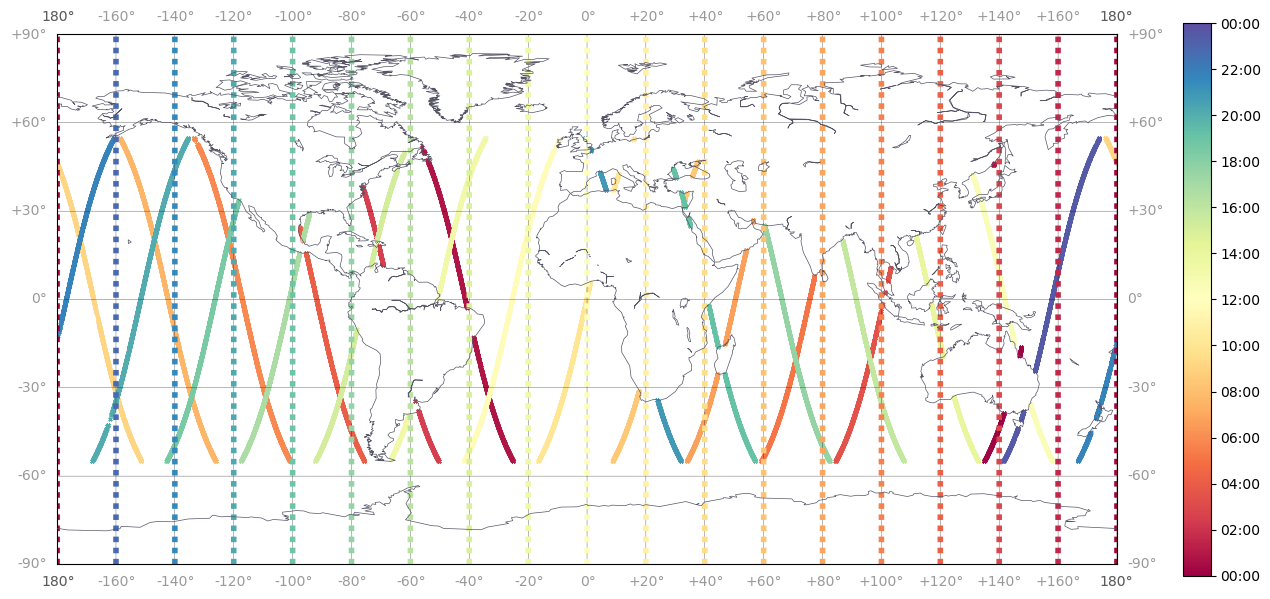

In [7]:
fig, ax = plt.subplots(figsize=(14,6))
earth=Basemap()

init_earth(earth)
show_sun_lines(earth)

for n in better_RADS:
    file = summary_files[pass_n_files.index(n)]
    plot_file(earth, file, extra=f'n={n:>02} ', label=None)


data = [dt_extra.get_datetime_obj(i) for i in ['00:00:00 22/01/2024', '00:00:00 23/01/2024']]
t = pd.date_range(start=data[0], end=data[1], periods=13, )
x = [0,1]
y = [0,1]
smap = ax.scatter(x,y,s=0.0001,c=mdates.date2num(data),edgecolors='none',marker='o',cmap='Spectral')

cb = fig.colorbar(smap,orientation='vertical',
                  ticks= mdates.HourLocator(interval=2),
                  format=mdates.DateFormatter('%H:%M'))


# ax.set_title('Paths in which RADS is better', pad=24)
fig.tight_layout()
plt.savefig(os.path.join(res_dir, 'paths_better_rads.svg'), dpi=300)

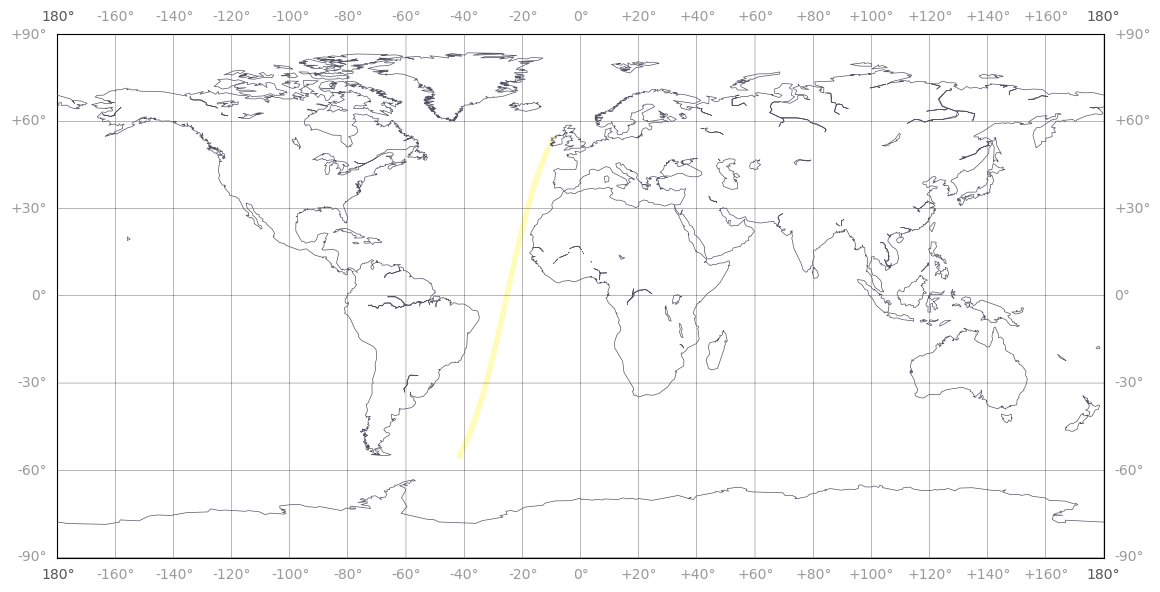

In [8]:
# all paths, individually
n = 15

fig, ax = plt.subplots(figsize=(14,6))
earth=Basemap()
init_earth(earth)  
# show_sun_lines(earth)
# show_jason_pos(earth)

file = summary_files[pass_n_files.index(n)]
plot_file(earth, file, extra=f'n={n:>02} ')

# ax.legend(bbox_to_anchor=(1.06, 0.99), loc='upper left')
# ax.set_title('Paths in which RADS is better', pad=24)

fig.tight_layout()
plt.savefig(os.path.join(res_dir, 'path_geomagnetic_equator.svg'), dpi=300)

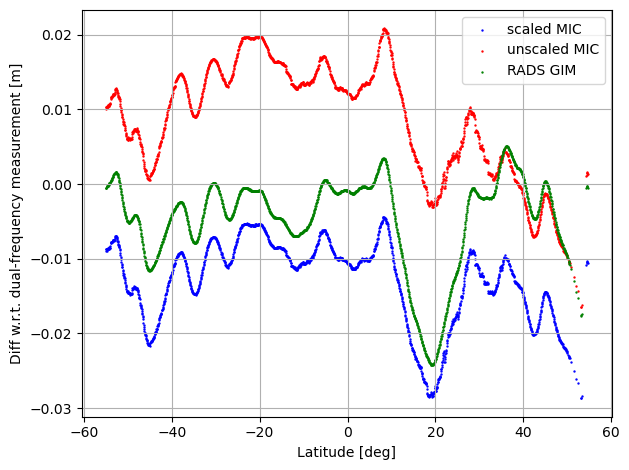

In [9]:
n = 15

file1 = summary_files[pass_n_files.index(n)]
file2 = r'results\2024-06-13 09.44 - S3A (pass 15) - a=0.9173 b=0.8994_raw.csv'
file_list = [file1]#, file2]
style_extra = [{'alpha':1}]#, {'alpha':1}]

for file, file_style in zip(file_list, style_extra):
    with open(file, 'r') as f: df = pd.read_table(f, sep=',', header=0, index_col=0)

    lon_array = df['Lon']
    lat_array = df['Lat']
    time_array = df['Time']

    MIC_unscaled_local = df['MIC Unscaled']
    MIC_local = df['MIC']
    RADS_local = df['RADS GIM']

    style = dict({'s': 0.5}, **file_style)
    plt.scatter(lat_array, MIC_local, label='scaled MIC', color='blue', **style)
    plt.scatter(lat_array, MIC_unscaled_local, label='unscaled MIC', color='red', **style)
    plt.scatter(lat_array, RADS_local, label='RADS GIM', color='green', **style)

plt.ylabel('Diff w.r.t. dual-frequency measurement [m]')

plt.xlabel('Latitude [deg]')
plt.grid()
plt.legend()#bbox_to_anchor=(1.06, 0.99), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(res_dir, 'path_15_latitude.svg'), dpi=300)


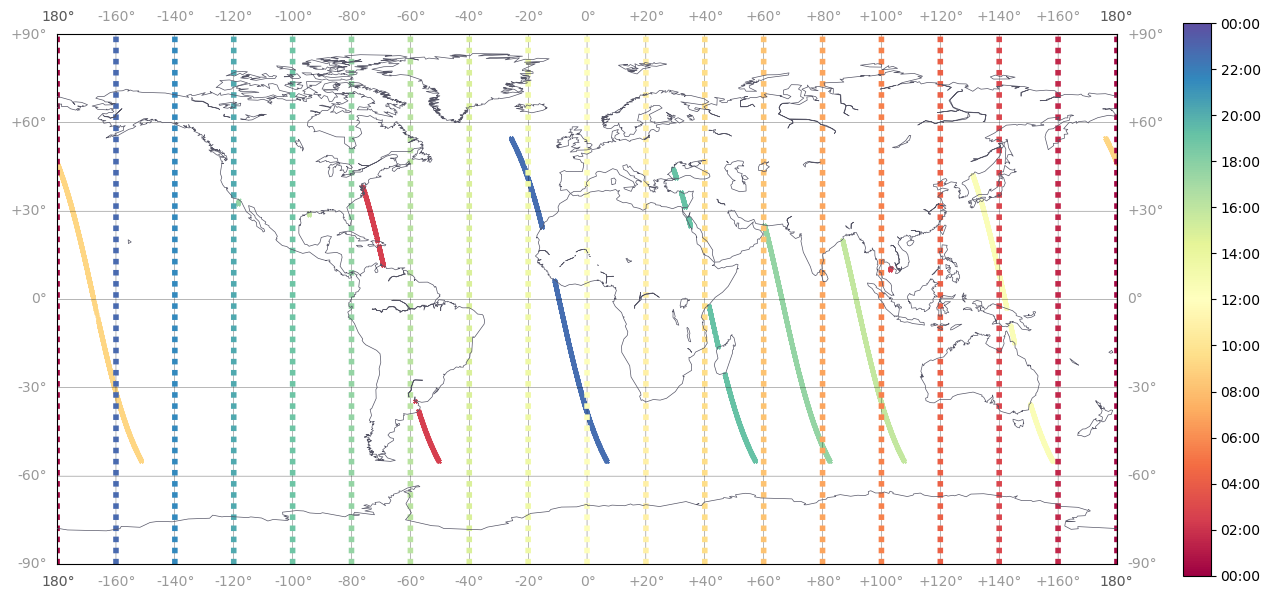

In [11]:
fig, ax = plt.subplots(figsize=(14,6))
earth=Basemap()

init_earth(earth)
show_sun_lines(earth)
# show_jason_pos(earth)

for n in better_unscaled:
    file = summary_files[pass_n_files.index(n)]
    plot_file(earth, file, extra=f'n={n:>02} ')


data = [dt_extra.get_datetime_obj(i) for i in ['00:00:00 22/01/2024', '00:00:00 23/01/2024']]
t = pd.date_range(start=data[0], end=data[1], periods=13, )
x = [0,1]
y = [0,1]
smap = ax.scatter(x,y,s=0.0001,c=mdates.date2num(data),edgecolors='none',marker='o',cmap='Spectral')

cb = fig.colorbar(smap,orientation='vertical',
                  ticks= mdates.HourLocator(interval=2),
                  format=mdates.DateFormatter('%H:%M'))

# ax.legend(bbox_to_anchor=(1.06, 0.99), loc='upper left')
# ax.set_title('Paths in which Unscaled MIC is better', pad=24)
fig.tight_layout()
plt.savefig(os.path.join(res_dir, 'paths_better_unscaled.svg'), dpi=300)


In [12]:
# getting full dataset

time_raw      = np.ndarray([])
diff_unscaled = np.ndarray([])
diff_MIC      = np.ndarray([])
diff_RADS     = np.ndarray([])
lon           = np.ndarray([])
lat           = np.ndarray([])

summary_df = pd.DataFrame(columns=['diff unscaled', 'diff MIC', 'diff RADS', 'time'])

for n, file in zip(pass_n_files, summary_files):
    with open(file, 'r') as f:
        df = pd.read_table(f, sep=',', header=0, index_col=0)
    
    time_raw = np.append(time_raw, df['Time'])
    diff_unscaled = np.append(diff_unscaled, df['MIC Unscaled'])
    diff_MIC = np.append(diff_MIC, df['MIC'])
    diff_RADS = np.append(diff_RADS, df['RADS GIM'])
    lat = np.append(lat, df['Lat'])
    lon = np.append(lon, df['Lon'])
    
    values = np.average([df['MIC Unscaled'], df['MIC'], df['RADS GIM']], axis=-1)
    
    summary_df.loc[n] = [*values, df['Time'][int(len(df['Time'])/2)]]

time = pd.to_datetime(time_raw)

time          = time[1:-2]
diff_unscaled = diff_unscaled[1:-2]
diff_MIC      = diff_MIC[1:-2]
diff_RADS     = diff_RADS[1:-2]
lon           = lon[1:-2]
lat           = lat[1:-2]

summary_df.loc['all'] = [*np.average([diff_unscaled, diff_MIC, diff_RADS], axis=-1), '-']
summary_df


,diff unscaled,diff MIC,diff RADS,time
1,0.003016,-0.009549,-0.002255,2024-01-22 00:08:15
2,0.003158,-0.008325,0.000523,2024-01-22 00:46:37
3,-0.000458,-0.010471,-0.002954,2024-01-22 02:31:14
4,0.008075,-0.009534,0.001921,2024-01-22 03:25:17
5,0.001937,-0.012864,0.001636,2024-01-22 04:03:06
6,0.011382,-0.008796,-0.000491,2024-01-22 05:05:15
7,0.004149,-0.007982,-0.001077,2024-01-22 05:48:48
8,0.004149,-0.007982,-0.001077,2024-01-22 05:48:48
9,0.008651,-0.014608,-0.007784,2024-01-22 06:43:14
10,0.005919,-0.006087,-0.000599,2024-01-22 07:30:11


In [ ]:
values = np.average([df['MIC Unscaled'], df['MIC'], df['RADS GIM']], axis=-1)
k = [*values, 0]
k

In [8]:
np.mean(diff_MIC), np.mean(diff_RADS), np.mean(diff_unscaled)

(-0.011698331129457094, -0.002190154786607589, 0.0044685989549906515)

In [9]:
np.std(diff_MIC), np.std(diff_RADS), np.std(diff_unscaled)

(0.01148425864160783, 0.012125557564243241, 0.011264398135476193)

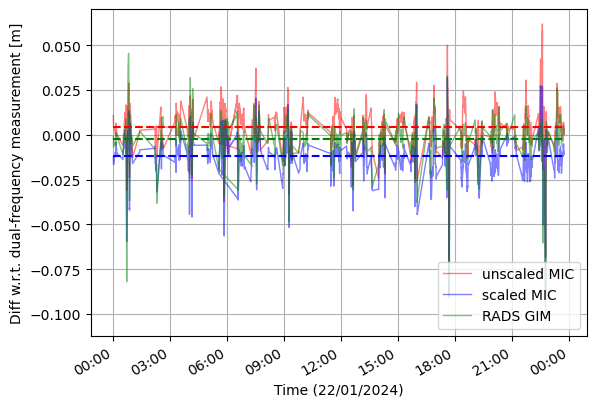

In [13]:
# order = 4
# diff_unscaled_filter = sp.signal.savgol_filter(diff_unscaled, len(diff_unscaled), order)
# diff_IMIC_filter = sp.signal.savgol_filter(diff_IMIC, len(diff_IMIC), order)
# diff_RADS_filter = sp.signal.savgol_filter(diff_RADS, len(diff_RADS), order)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()

main_style = {'alpha': 0.5, 'lw':1}

plt.plot(time, diff_unscaled,        color='red', label=r'unscaled MIC', **main_style)
plt.plot(time, diff_MIC,             color='blue', label=r'scaled MIC', **main_style)
plt.plot(time, diff_RADS,            color='green', label='RADS GIM', **main_style)
plt.hlines(np.average(diff_unscaled), np.min(time), np.max(time), color='red', ls='--')#, label=r'unscaled MIC')
plt.hlines(np.average(diff_MIC), np.min(time),      np.max(time), color='blue', ls='--') #, label='scaled MIC')
plt.hlines(np.average(diff_RADS), np.min(time),     np.max(time), color='green', ls='--') #, label='RADS GIM')
plt.plot()
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Time (22/01/2024)')
plt.ylabel('Diff w.r.t. dual-frequency measurement [m]')
plt.savefig(os.path.join(res_dir, 'all_paths_time.svg'), dpi=300)
